

# Source localization with MNE, dSPM, sLORETA, and eLORETA

The aim of this tutorial is to teach you how to compute and apply a linear
minimum-norm inverse method on evoked/raw/epochs data.


In [1]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse, make_inverse_operator

Compute ERPs/ERFs again



Opening raw data file C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  

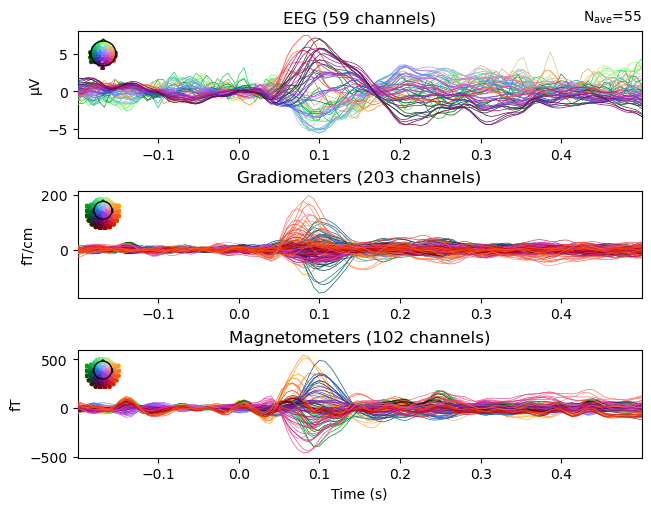

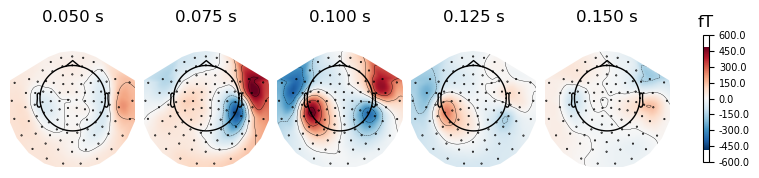

In [20]:
data_path = sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"

raw = mne.io.read_raw_fif(raw_fname)  # already has an average reference
events = mne.find_events(raw, stim_channel="STI 014")

event_id = dict(aud_l=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info["bads"] = ["MEG 2443", "EEG 053"]
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("meg", "eeg", "eog"),
    baseline=baseline,
    reject=reject,
)

evoked = epochs.average()
evoked.plot(time_unit="s")
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type="mag");

## Compute regularized noise covariance
For more details see `tut-compute-covariance`.



Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
17 bad epochs dropped
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (witho

C:\Users\olaf\AppData\Local\Temp\ipykernel_14056\2797516010.py:3: RuntimeWarning: Too few samples (required : 1825 got : 1705), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(


Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 1705
log-likelihood on unseen data (descending order):
   shrunk: -1587.792
   empirical: -1846.748
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 5.5e-14 (2.2e-16 eps * 59 dim * 4.2  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors


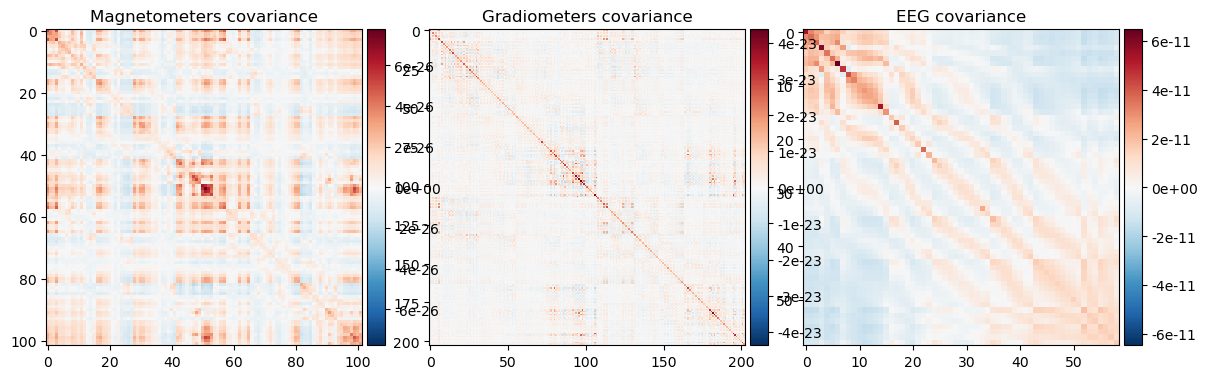

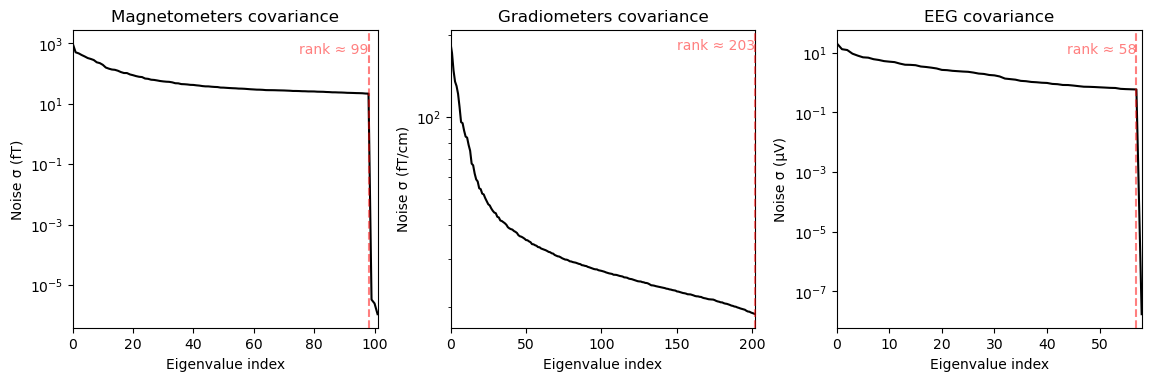

In [21]:
# only baseline interval is used
# the best of two options will be picked
noise_cov = mne.compute_covariance(
    epochs, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=True
)

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

Now we can look at "whitenened" data, i.e. data normalised by the inverse of the covariance matrix. This turns every channel type into signal-to-noise ratios, i.e. comparable units. It is also a pre-requisite to combine channel types in source estimation (and classification etc.).

We should check that our noise covariance matrix is appropriate for whitening our evoked data before source estimation.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 5.5e-14 (2.2e-16 eps * 59 dim * 4.2  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 203 dim * 3.5  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.98  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank={'eeg': 58, 'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
    Cre

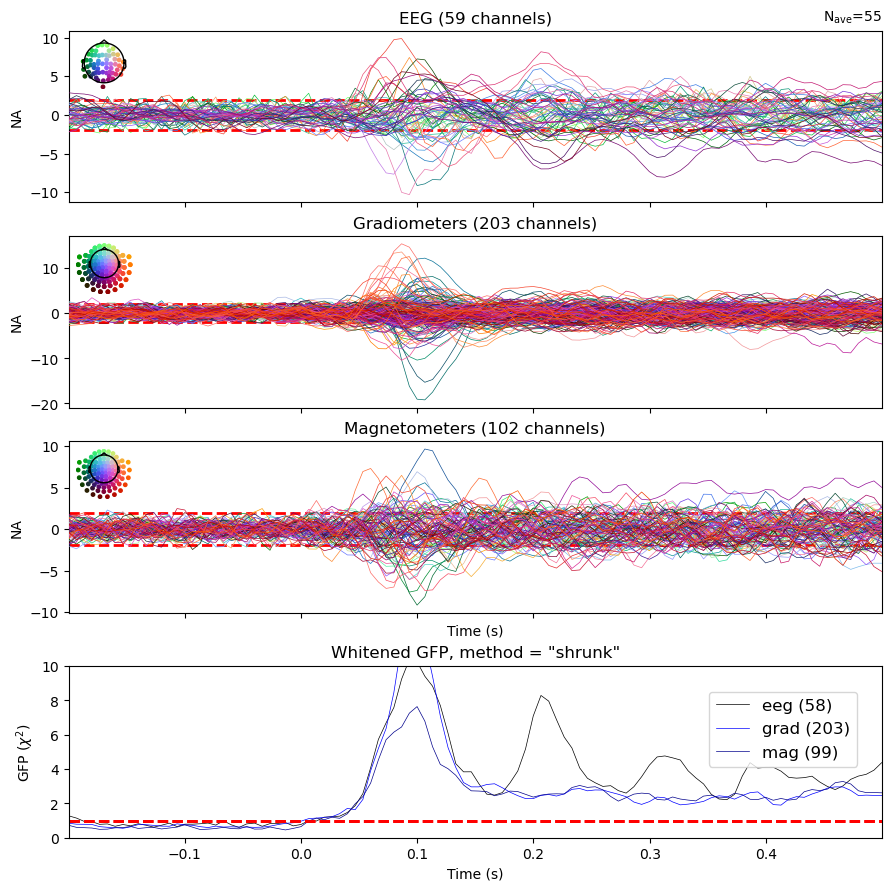

In [22]:
evoked.plot_white(noise_cov, time_unit="s");

## Inverse modeling: MNE/dSPM on evoked and raw data
We now have all the ingredients for source estimation@
* The data (here ERPs/ERFs).
* The forward solution (source space, head model, co-registration).
* The noise covariance matrix.

Here we now read the forward solution from a previous step. You will likely need to compute
one for your own data -- see `tut-forward` for information on how
to do it.



In [23]:
fname_fwd = data_path / "MEG" / "sample" / "sample_audvis-meg-oct-6-fwd.fif"
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


We are ready to put everything together to make an MEG inverse operator.

Note that we can choose parameters for source orientation ("loose") and depth weighting ("depth") here.



In [24]:
inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, loose=0.2, depth=None
)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 306 channels remain after picking
Selected 305 channels
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 305 dim * 4.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular 

<div class="alert alert-info"><h4>Note</h4><p>You can write the inverse operator to disk with:

```
from mne.minimum_norm import write_inverse_operator
write_inverse_operator(
    "sample_audvis-meg-oct-6-inv.fif", inverse_operator
)</p></div>
```
## Compute inverse solution
We can use this to compute the inverse solution and obtain source time
courses:



The inverse operator is independent of the data (apart from the covariance matrix, which reflects the noise whose structure should not change across conditions within the same session).

We can now apply the inverse operator to any data that are consistent with its sensor configuration (i.e. sensor locations and co-registration) and noise structure (i.e. covariance matrix).

In [34]:
method = "MNE"  # source estimation method
snr = 3.  # signal-to-noise ratio...
lambda2 = 1.0 / snr**2  # ...is translated into a regularisation parameter to suppress noise
stc, residual = apply_inverse(
    evoked,
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,  # whether to return signed amplitudes, free orientations, or intensities
    return_residual=True,
    verbose=True,
)
# this return a Source Time Course (STC) object, which contains source time courses for every vertex

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
Applying inverse operator to "aud_l"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.6% variance
    Combining the current components...
[done]


In [39]:
apply_inverse?

Signature:
apply_inverse(
    evoked,
    inverse_operator,
    lambda2=0.1111111111111111,
    method='dSPM',
    pick_ori=None,
    prepared=False,
    label=None,
    method_params=None,
    return_residual=False,
    use_cps=True,
    verbose=None,
)
Docstring:
Apply inverse operator to evoked data.

Parameters
----------
evoked : Evoked object
    Evoked data.
inverse_operator : instance of InverseOperator
    Inverse operator.
lambda2 : float
    The regularization parameter.
method : "MNE" | "dSPM" | "sLORETA" | "eLORETA"
    Use minimum norm :footcite:`HamalainenIlmoniemi1994`,
    dSPM (default) :footcite:`DaleEtAl2000`,
    sLORETA :footcite:`Pascual-Marqui2002`, or
    eLORETA :footcite:`Pascual-Marqui2011`.

pick_ori : None | "normal" | "vector"

    Options:

    - ``None``
        Pooling is performed by taking the norm of loose/free
        orientations. In case of a fixed source space no norm is computed
        leading to signed source activity.
    - ``"normal"``
    

In [35]:
print(stc)
print(stc.data.shape)

<SourceEstimate | 7498 vertices, subject : sample, tmin : -199.79521315838787 (ms), tmax : 499.48803289596964 (ms), tstep : 6.659840438612929 (ms), data shape : (7498, 106), ~6.1 MiB>
(7498, 106)


## Visualization
Before we plot a fancy brain, we remind ourselves that we are dealing with spatio-temporal data, i.e. time courses per vertex.


[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'MNE value')]

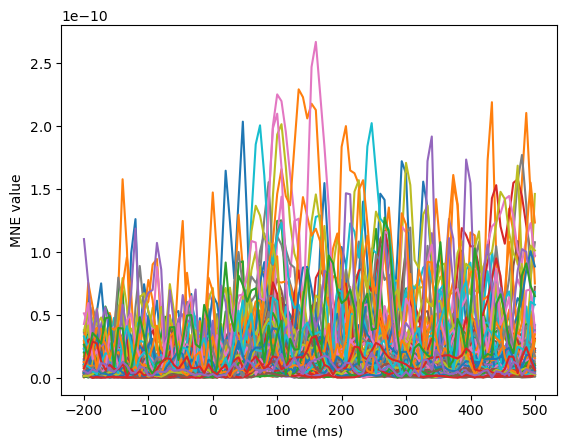

In [36]:
fig, ax = plt.subplots()
ax.plot(1e3 * stc.times, stc.data[::100, :].T)
ax.set(xlabel="time (ms)", ylabel="%s value" % method)

Examine the original data and the residual after fitting:



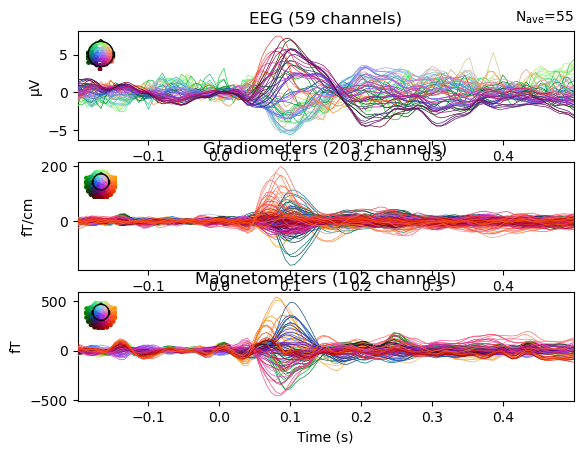

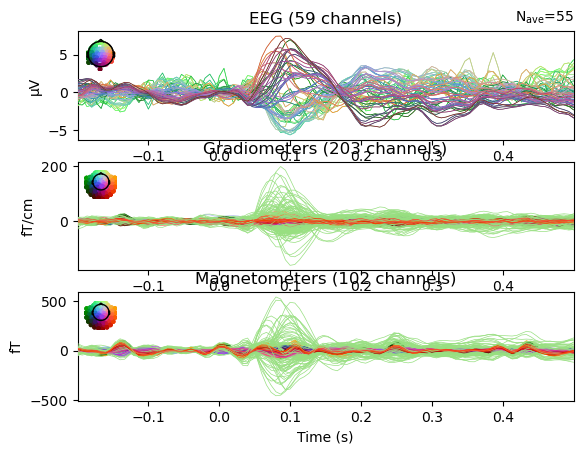

In [37]:
fig, axes = plt.subplots(3, 1)
evoked.plot(axes=axes);
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color("#98df81")
residual.plot(axes=axes)

Now we are ready to look at the source estimate in its whole glory.

Here we use peak getter to move visualization to the time point of the peak
and draw a marker at the maximum peak vertex.



In [40]:
vertno_max, time_max = stc.get_peak(hemi="rh")

# scale plots with respect to global maximum
maxamp = stc.data.max()
lims = (0, maxamp/2., maxamp)

subjects_dir = data_path / "subjects"
surfer_kwargs = dict(
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=lims),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain.add_text(
    0.1, 0.9, method + " (plus location of maximal activation)", "title", font_size=14
)

# Note: You can save your results as a movie.
# The documentation website's movie is generated with:
# brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear',
#                  time_dilation=20, framerate=10, time_viewer=True)

Using pyvistaqt 3d backend.
False


There are many other ways to visualize and work with source data, see
for example:

- `tut-viz-stcs`
- `ex-morph-surface`
- `ex-morph-volume`
- `ex-vector-mne-solution`
- `tut-dipole-orientations`
- `tut-mne-fixed-free`
- `examples using apply_inverse
  <sphx_glr_backreferences_mne.minimum_norm.apply_inverse>`.



Exercises:
* use different methods
* look at different conditions
* Change the view (e.g. show both hemispheres)
* use only EEG or MEG
* use different regularisation parameters
* use different source orientations

## Beamforming

Loading data for 55 events and 106 original time points ...
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Number of samples used : 2035
[done]
Loading data for 55 events and 106 original time points ...
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK


C:\Users\olaf\AppData\Local\Temp\ipykernel_14056\1163647183.py:3: RuntimeWarning: Too few samples (required : 1825 got : 1705), covariance estimate may be unreliable
  noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method="shrunk")


Done.
Number of samples used : 1705
[done]
Computing rank from covariance with rank=None
    Using tolerance 3.9e-14 (2.2e-16 eps * 102 dim * 1.7  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 4.2e-13 (2.2e-16 eps * 203 dim * 9.3  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 8.2e-14 (2.2e-16 eps * 59 dim * 6.3  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors


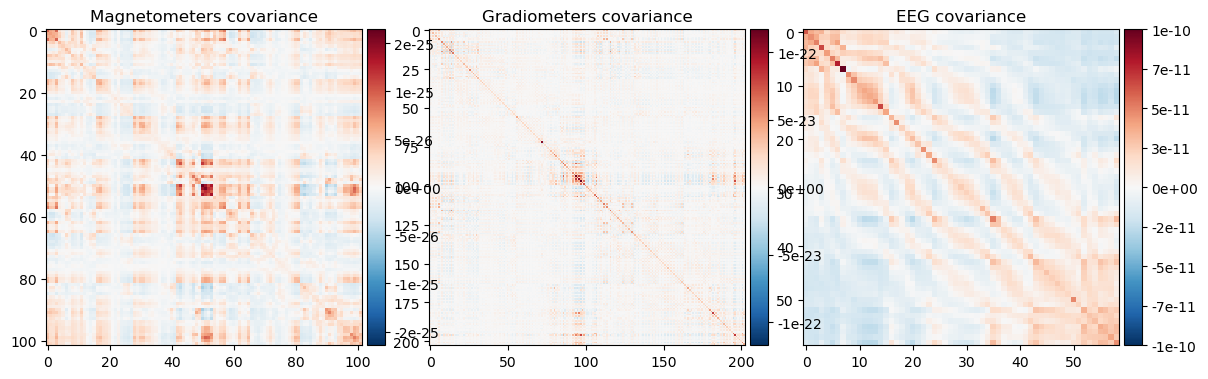

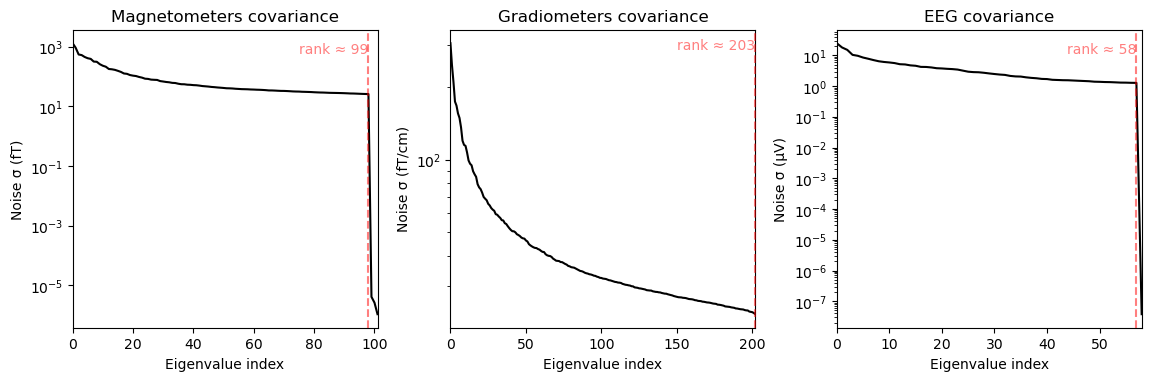

(<Figure size 1140x370 with 6 Axes>, <Figure size 1140x370 with 3 Axes>)

In [45]:
# Beamforming requires a "data" and a "noise" covariance matrix
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=0.25, method="shrunk")
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0, method="shrunk")
data_cov.plot(epochs.info)

In [42]:
filters = mne.beamformer.make_lcmv(
    evoked.info,
    fwd,
    data_cov,
    reg=0.05,
    noise_cov=noise_cov,
    rank=None,
)

# You can save the filter for later use with:
# filters.save('filters-lcmv.h5')filters = make_lcmv(

Excluding 59 channel(s) missing from the provided forward operator and/or covariance matrices
Computing rank from covariance with rank=None
    Using tolerance 7e-13 (2.2e-16 eps * 305 dim * 10  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 305 dim * 4.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
Making LCMV beamformer with rank {'meg': 302}
Computing inverse operator with 305 channels.
    305 out of 306 channels remain after picking
Selected 305 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank={'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamforme

In [43]:
# apply beamformer weights to real data
# note: the data should correspond to the data covariance matrix
stc_bf = mne.beamformer.apply_lcmv(evoked, filters)

combining the current components...


In [44]:
# visualize the result

vertno_max, time_max = stc_bf.get_peak(hemi="rh")

# scale plots with respect to global maximum
maxamp = np.abs(stc_bf.data).max()  # note: absolute value
lims = (0, maxamp/2., 2*maxamp)

subjects_dir = data_path / "subjects"
surfer_kwargs = dict(
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=lims),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain_bf = stc_bf.plot(**surfer_kwargs)
brain_bf.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain_bf.add_text(
    0.1, 0.9, "LCMV beamformer (plus location of maximal activation)", "title", font_size=14
)

False


# Exercises:
* How does make_lcmv deal with source orientations? Check the option 'vector'.
* Check regularization options for data and noise covariance matrices.
* Analyze different conditions (note: change data covariance matrix).
* Compare EEG and MEG.